# ДЗ 06. ML для бизнеса

1. [повторить анализ набора данных WA_Fn-UseC_-Telco-Customer-Churn.csv (желательно придумать какие-то дополнительные признаки)](#task01)
2. [дополнить список моделей еще как минимум тремя (lightgbm, xgboost, svm, knn, naivebayes, сети, что-то еще)](#task02)
3. [на выходе сформировать единую таблицу метрик качества со всеми моделями](#task03) 
4. [сделать выводы о том, какие модели лучше справляются с задачей прогноза оттока на этой выборке](#task04)
5. [есть ли смысл в этапе отборе признаков с точки зрения повышения качества прогнозов](#task05)
6. [(опционально) сделать подбор параметров (без особого усердия) для лучшей (можно нескольких) моделей и проверить качество снова](#task06)

In [21]:
import pandas as pd
import numpy as np

# Input data files are available in the "../input/" directory.
import os
import matplotlib.pyplot as plt#visualization
from PIL import  Image
%matplotlib inline
import pandas as pd
import seaborn as sns#visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

/Users/artem/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Задание 1.<a class="anchor" id="task01"></a>

повторить анализ набора данных WA_Fn-UseC_-Telco-Customer-Churn.csv (желательно придумать какие-то дополнительные признаки)

In [3]:
pwd

'/Users/artem/Movies/ML_buisness_course/lesson06'

In [4]:
telcom = pd.read_csv('/Users/artem/Movies/ML_buisness_course/lesson06/WA_Fn-UseC_-Telco-Customer-Churn.csv')
telcom.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [5]:
indexes = telcom[telcom['TotalCharges']==' '].index.tolist()
indexes

[488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]

### Data Manipulation

#### столбец 'TotalCharges'

In [6]:
#Data Manipulation

#Replacing spaces with null values in total charges column
telcom['TotalCharges'] = telcom["TotalCharges"].replace(" ",np.nan) # заменяем пробелы NaN-значениями

In [7]:
#Dropping null values from total charges column which contain .15% missing data 
telcom = telcom[telcom["TotalCharges"].notnull()] # удаляем строки с NaN значениями (всего 11 штук) по столбцу total Charges

In [8]:
telcom = telcom.reset_index()[telcom.columns] # меняем значения индекса с учётом удалённых строк

In [9]:
#convert to float type
telcom["TotalCharges"] = telcom["TotalCharges"].astype(float) # назначем тип данных float

#### Повторяющиеся в разных столбцах значения 'No internet service'

In [10]:
#replace 'No internet service' to No for the following columns
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    telcom[i]  = telcom[i].replace({'No internet service' : 'No'})

#### Признак "SeniorCitizen" превращаем в категориальный yes/no

In [11]:
#replace values
telcom["SeniorCitizen"] = telcom["SeniorCitizen"].replace({1:"Yes",0:"No"})

#### Признак "Tenure" превращаем в категориальный из цифрового

In [12]:
#Tenure to categorical column
def tenure_lab(telcom) :
    
    if telcom["tenure"] <= 12 :
        return "Tenure_0-12"
    elif (telcom["tenure"] > 12) & (telcom["tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (telcom["tenure"] > 24) & (telcom["tenure"] <= 48) :
        return "Tenure_24-48"
    elif (telcom["tenure"] > 48) & (telcom["tenure"] <= 60) :
        return "Tenure_48-60"
    elif telcom["tenure"] > 60 :
        return "Tenure_gt_60"
telcom["tenure_group"] = telcom.apply(lambda telcom:tenure_lab(telcom),
                                      axis = 1)

#### Разделим датасет на две части по условию принадлежности к меткам классов

In [13]:
#Separating churn and non churn customers
churn     = telcom[telcom["Churn"] == "Yes"] # клиенты с меткой "yes" в один датасет
not_churn = telcom[telcom["Churn"] == "No"] # с меткой 'no' в другой

#### Разделение на категориальные и количественные столбцы

In [14]:
#Separating catagorical and numerical columns
Id_col     = ['customerID']
target_col = ["Churn"]
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist() # вывести все признаки(столбцы), в котором меньше 6 категорий

In [15]:
cat_cols   = [x for x in cat_cols if x not in target_col] # убираем столбец с таргетом из категориальных признаков
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col] #  все остальные столбцы (признаки) относим к количественным

### EDA

In [24]:
#labels
lab = telcom["Churn"].value_counts().keys().tolist()
#values
val = telcom["Churn"].value_counts().values.tolist()
lab, val

(['No', 'Yes'], [5163, 1869])

Наблюдаем дисбаланс классов!

In [25]:

trace = go.Pie(labels = lab ,
               values = val ,
               marker = dict(colors =  [ 'royalblue' ,'lime'],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Customer attrition in data",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)

In [27]:
#function  for pie plot for customer attrition types
def plot_pie(column) :
    
    trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
                    labels  = churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Churn Customers",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    hole    = .6
                   )
    trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
                    labels  = not_churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Non churn customers" 
                   )


    layout = go.Layout(dict(title = column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .15, y = .5),
                                           dict(text = "Non churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .88,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)


#function  for histogram for customer attrition types
def histogram(column) :
    trace1 = go.Histogram(x  = churn[column],
                          histnorm= "percent",
                          name = "Churn Customers",
                          marker = dict(line = dict(width = .5,
                                                    color = "black"
                                                    )
                                        ),
                         opacity = .9 
                         ) 
    
    trace2 = go.Histogram(x  = not_churn[column],
                          histnorm = "percent",
                          name = "Non churn customers",
                          marker = dict(line = dict(width = .5,
                                              color = "black"
                                             )
                                 ),
                          opacity = .9
                         )
    
    data = [trace1,trace2]
    layout = go.Layout(dict(title =column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = column,
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                           )
                      )
    fig  = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)
    
#function  for scatter plot matrix  for numerical columns in data
def scatter_matrix(df)  :
    
    df  = df.sort_values(by = "Churn" ,ascending = True)
    classes = df["Churn"].unique().tolist()
    classes
    
    class_code  = {classes[k] : k for k in range(2)}
    class_code

    color_vals = [class_code[cl] for cl in df["Churn"]]
    color_vals

    pl_colorscale = "Portland"

    pl_colorscale

    text = [df.loc[k,"Churn"] for k in range(len(df))]
    text

    trace = go.Splom(dimensions = [dict(label  = "tenure",
                                       values = df["tenure"]),
                                  dict(label  = 'MonthlyCharges',
                                       values = df['MonthlyCharges']),
                                  dict(label  = 'TotalCharges',
                                       values = df['TotalCharges'])],
                     text = text,
                     marker = dict(color = color_vals,
                                   colorscale = pl_colorscale,
                                   size = 3,
                                   showscale = False,
                                   line = dict(width = .1,
                                               color='rgb(230,230,230)'
                                              )
                                  )
                    )
    axis = dict(showline  = True,
                zeroline  = False,
                gridcolor = "#fff",
                ticklen   = 4
               )
    
    layout = go.Layout(dict(title  = 
                            "Scatter plot matrix for Numerical columns for customer attrition",
                            autosize = False,
                            height = 800,
                            width  = 800,
                            dragmode = "select",
                            hovermode = "closest",
                            plot_bgcolor  = 'rgba(240,240,240, 0.95)',
                            xaxis1 = dict(axis),
                            yaxis1 = dict(axis),
                            xaxis2 = dict(axis),
                            yaxis2 = dict(axis),
                            xaxis3 = dict(axis),
                            yaxis3 = dict(axis),
                           )
                      )
    data   = [trace]
    fig = go.Figure(data = data,layout = layout )
    py.iplot(fig)

#for all categorical columns plot pie
for i in cat_cols :
    plot_pie(i)

#for all categorical columns plot histogram    
for i in num_cols :
    histogram(i)

#scatter plot matrix
scatter_matrix(telcom)

In [28]:
telcom[['MonthlyCharges', 'TotalCharges','tenure',"tenure_group"]]

#scatter plot monthly charges & total charges by tenure group

def plot_tenure_scatter(tenure_group,color) :
    tracer = go.Scatter(x = telcom[telcom["tenure_group"] == tenure_group]["MonthlyCharges"],
                        y = telcom[telcom["tenure_group"] == tenure_group]["TotalCharges"],
                        mode = "markers",marker = dict(line = dict(color = "black",
                                                                   width = .2),
                                                       size = 4 , color = color,
                                                       symbol = "diamond-dot",
                                                      ),
                        name = tenure_group,
                        opacity = .9
                       )
    return tracer

#scatter plot monthly charges & total charges by churn group
def plot_churncharges_scatter(churn,color) :
    tracer = go.Scatter(x = telcom[telcom["Churn"] == churn]["MonthlyCharges"],
                        y = telcom[telcom["Churn"] == churn]["TotalCharges"],
                        mode = "markers",marker = dict(line = dict(color = "black",
                                                                   width = .2),
                                                       size = 4 , color = color,
                                                       symbol = "diamond-dot",
                                                      ),
                        name = "Churn - " + churn,
                        opacity = .9
                       )
    return tracer

trace1 = plot_tenure_scatter("Tenure_0-12","#FF3300")
trace2 = plot_tenure_scatter("Tenure_12-24","#6666FF")
trace3 = plot_tenure_scatter("Tenure_24-48","#99FF00")
trace4 = plot_tenure_scatter("Tenure_48-60","#996600")
trace5 = plot_tenure_scatter("Tenure_gt_60","grey")
trace6 = plot_churncharges_scatter("Yes","red")
trace7 = plot_churncharges_scatter("No","blue")

data1   = [trace1,trace2,trace3,trace4,trace5] 
data2   = [trace7,trace6]

#layout
def layout_title(title) :
    layout = go.Layout(dict(title = title,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         title = "Monthly charges",
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         title = "Total Charges",
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            height = 600
                           )
                      )
    return layout

layout1  = layout_title("Monthly Charges & Total Charges by Tenure group")
layout2  = layout_title("Monthly Charges & Total Charges by Churn group")
fig1 = go.Figure(data = data1,layout = layout1)
fig2 = go.Figure(data = data2,layout = layout2)
py.iplot(fig1)
py.iplot(fig2)

In [29]:
avg_tgc = telcom.groupby(["tenure_group","Churn"])[["MonthlyCharges",
                                                    "TotalCharges"]].mean().reset_index()

#function for tracing 
def mean_charges(column,aggregate) :
    tracer = go.Bar(x = avg_tgc[avg_tgc["Churn"] == aggregate]["tenure_group"],
                    y = avg_tgc[avg_tgc["Churn"] == aggregate][column],
                    name = aggregate,marker = dict(line = dict(width = 1)),
                    text = "Churn"
                   )
    return tracer

#function for layout
def layout_plot(title,xaxis_lab,yaxis_lab) :
    layout = go.Layout(dict(title = title,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = xaxis_lab,
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = yaxis_lab,
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                           )
                      )
    return layout
    

#plot1 - mean monthly charges by tenure groups
trace1  = mean_charges("MonthlyCharges","Yes")
trace2  = mean_charges("MonthlyCharges","No")
layout1 = layout_plot("Average Monthly Charges by Tenure groups",
                      "Tenure group","Monthly Charges")
data1   = [trace1,trace2]
fig1    = go.Figure(data=data1,layout=layout1)

#plot2 - mean total charges by tenure groups
trace3  = mean_charges("TotalCharges","Yes")
trace4  = mean_charges("TotalCharges","No")
layout2 = layout_plot("Average Total Charges by Tenure groups",
                      "Tenure group","Total Charges")
data2   = [trace3,trace4]
fig2    = go.Figure(data=data2,layout=layout2)

py.iplot(fig1)
py.iplot(fig2)

In [30]:
##copy data
tel_df = telcom.copy()
#Drop tenure column
#telcom = telcom.drop(columns = "tenure_group",axis = 1)

### Data preprocessing

In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#### Определим столбцы с бинарными данными и где значений признака больше двух

In [36]:
bin_cols   = telcom.nunique()[telcom.nunique() == 2].keys().tolist() # определяем столбцы, где только два значения признака
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols] # определяем столбцы, где значений больше, чем два

#### Кодировка столбцов с бинарными признаками

In [41]:
#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    telcom[i] = le.fit_transform(telcom[i])

#### Из категориальных столбцов, содержащих множественные (больше двух) значений создаём бинарные признаки (новые столбцы)

In [43]:
#Duplicating columns for multi value columns
telcom = pd.get_dummies(data = telcom,columns = multi_cols )

#### Стандартизируем данные и вставляем в датасет

In [50]:
#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(telcom[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

In [51]:
#dropping original values merging scaled values for numerical columns
df_telcom_og = telcom.copy()
telcom = telcom.drop(columns = num_cols,axis = 1)
telcom = telcom.merge(scaled,left_index=True,right_index=True,how = "left")

In [53]:
summary = (df_telcom_og[[i for i in df_telcom_og.columns if i not in Id_col]].
           describe().transpose().reset_index())

summary = summary.rename(columns = {"index" : "feature"})
summary = np.around(summary,3)

val_lst = [summary['feature'], summary['count'],
           summary['mean'],summary['std'],
           summary['min'], summary['25%'],
           summary['50%'], summary['75%'], summary['max']]

trace  = go.Table(header = dict(values = summary.columns.tolist(),
                                line = dict(color = ['#506784']),
                                fill = dict(color = ['#119DFF']),
                               ),
                  cells  = dict(values = val_lst,
                                line = dict(color = ['#506784']),
                                fill = dict(color = ["lightgrey",'#F5F8FF'])
                               ),
                  columnwidth = [200,60,100,100,60,60,80,80,80])
layout = go.Layout(dict(title = "Variable Summary"))
figure = go.Figure(data=[trace],layout=layout)
py.iplot(figure)

In [54]:
#correlation
correlation = telcom.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data = [trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

In [57]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

X = telcom[[i for i in telcom.columns if i not in Id_col + target_col]]
Y = telcom[target_col + Id_col]

principal_components = pca.fit_transform(X)
pca_data = pd.DataFrame(principal_components,columns = ["PC1","PC2"])
pca_data = pca_data.merge(Y,left_index=True,right_index=True,how="left")
pca_data["Churn"] = pca_data["Churn"].replace({1:"Churn",0:"Not Churn"})

def pca_scatter(target,color) :
    tracer = go.Scatter(x = pca_data[pca_data["Churn"] == target]["PC1"] ,
                        y = pca_data[pca_data["Churn"] == target]["PC2"],
                        name = target,mode = "markers",
                        marker = dict(color = color,
                                      line = dict(width = .5),
                                      symbol =  "diamond-open"),
                        text = ("Customer Id : " + 
                                pca_data[pca_data["Churn"] == target]['customerID'])
                       )
    return tracer

layout = go.Layout(dict(title = "Visualising data with principal components",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "principal component 1",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "principal component 2",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        height = 600
                       )
                  )
trace1 = pca_scatter("Churn",'red')
trace2 = pca_scatter("Not Churn",'royalblue')
data = [trace2,trace1]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

### Моделирование

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
from yellowbrick.classifier import DiscriminationThreshold
from sklearn.datasets import make_classification

#### Обучающая и тестовые выборки

In [167]:
#splitting train and test data 
train,test = train_test_split(telcom,test_size = .25 ,random_state = 111) # тестовая выборка 25% от всего датасета

##seperating dependent and independent variables
cols    = [i for i in telcom.columns if i not in Id_col + target_col] # список столбцов, которые будем скармливать моделям
train_X = train[cols] # трейн-выборка признаки
train_Y = train[target_col] # трейн-таргеты
test_X  = test[cols] # тест-выборка признаки
test_Y  = test[target_col] # тест-таргеты

In [62]:
#Function attributes
#dataframe     - processed dataframe
#Algorithm     - Algorithm used 
#training_x    - predictor variables dataframe(training)
#testing_x     - predictor variables dataframe(testing)
#training_y    - target variable(training)
#training_y    - target variable(testing)
#cf - ["coefficients","features"](cooefficients for logistic 
                                 #regression,features for tree based models)

#threshold_plot - if True returns threshold plot for model
    
def telecom_churn_prediction(algorithm,training_x,testing_x,
                             training_y,testing_y,cols,cf,threshold_plot) :
    
    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    #coeffs
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df     = pd.DataFrame(cols)
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix ,
                        x = ["Not churn","Churn"],
                        y = ["Not churn","Churn"],
                        showscale  = False,colorscale = "Picnic",
                        name = "matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #plot coeffs
    trace4 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Picnic",
                                  line = dict(width = .6,color = "black")))
    
    #subplots
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic',
                                            'Feature Importances'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)
    
    fig['layout'].update(showlegend=False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                        tickangle = 90))
    py.iplot(fig)
    
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1268
           1       0.69      0.53      0.60       490

    accuracy                           0.80      1758
   macro avg       0.76      0.72      0.73      1758
weighted avg       0.79      0.80      0.79      1758

Accuracy   Score :  0.8026166097838453
Area under curve :  0.7185443893645785 



/Users/artem/opt/anaconda3/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



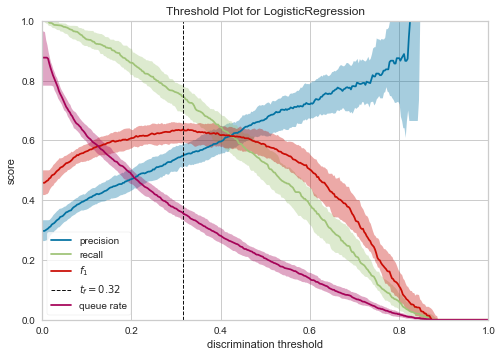

In [63]:
logit  = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

telecom_churn_prediction(logit,train_X,test_X,train_Y,test_Y,
                         cols,"coefficients",threshold_plot = True)

## Задание 2<a class="anchor" id="task02"></a>

Дополнить список моделей еще как минимум тремя (lightgbm, xgboost, svm, knn, naivebayes, сети, что-то еще)

In [65]:
from sklearn.metrics import precision_recall_fscore_support

Чтобы протестить несколько моделей, нужно чуть переделать предыдущую функцию telecom_churn_prediction:

In [115]:
def telecom_churn_prediction2(algorithm,training_x,testing_x,
                             training_y,testing_y,cols):
    
    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    
    acc_score = accuracy_score(testing_y,predictions)
#     print (algorithm)
#     print ("\n Classification report : \n",classification_report(testing_y,predictions))
#     print ("Accuracy   Score : ",acc_score)
    
#     info = precision_recall_fscore_support(testing_y,predictions, average='weighted')
#     print(info)
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    #print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
    item = {'algorithm': algorithm, 'accuracy_score':acc_score, 'ROC_AUC':model_roc_auc }
    
    return item

#### Сделаем ещё модели на основе: Случайного леса, G-boost, KNN, градиентного бустинга

In [168]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [169]:
model_xgb = xgb.XGBClassifier(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.01,
                max_depth = 10, alpha = 10, n_estimators = 1000, random_state=41)

In [170]:
random_forest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=2, max_features=7)

In [171]:
grad_boost = GradientBoostingClassifier(n_estimators=1000, max_features=7, max_depth=10, random_state=9)

In [172]:
model_knn = KNeighborsClassifier(n_neighbors=5)

Создадим список моделей, чтобы перебирать их в цикле

In [173]:
list_of_models = [logit, model_xgb, random_forest, grad_boost, model_knn]
results = []

In [174]:
results

[]

In [175]:
for ind, model in enumerate(list_of_models):
    
    item = telecom_churn_prediction2(model,train_X,test_X,train_Y,test_Y,
                         cols)
    
    print(ind, item)
    results.append(item)

0 {'algorithm': LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear'), 'accuracy_score': 0.8026166097838453, 'ROC_AUC': 0.7185443893645785}
1 {'algorithm': XGBClassifier(alpha=10, colsample_bytree=0.3, learning_rate=0.01, max_depth=10,
              n_estimators=1000, objective='reg:squarederror', random_state=41), 'accuracy_score': 0.7901023890784983, 'ROC_AUC': 0.6935910641859266}
2 {'algorithm': RandomForestClassifier(max_depth=10, max_features=7, n_estimators=1000,
                       random_state=2), 'accuracy_score': 0.7957906712172924, 'ROC_AUC': 0.6969081954548381}
3 {'algorithm': GradientBoostingClassifier(max_depth=10, max_features=7, n_estimators=1000,
                           random_state=9), 'accuracy_score': 0.7713310580204779, 'ROC_AUC': 0.679952359492693}
4 {'algorithm': KNeighborsClassifier(), 'accuracy_score': 0.7627986348122867, 'ROC_AUC': 0.6815505697547157}


## Задание 3 <a class="anchor" id="task03"></a>

на выходе сформировать единую таблицу метрик качества со всеми моделями

In [176]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['accuracy_score'],ascending=False)
results_df

algorithm  accuracy_score   ROC_AUC
0  LogisticRegression(multi_class='ovr', n_jobs=1...        0.802617  0.718544
2  (DecisionTreeClassifier(max_depth=10, max_feat...        0.795791  0.696908
1  XGBClassifier(alpha=10, colsample_bytree=0.3, ...        0.790102  0.693591
3  ([DecisionTreeRegressor(criterion='friedman_ms...        0.771331  0.679952
4                             KNeighborsClassifier()        0.762799  0.681551

## Задание 4 <a class='anchor' id='task04'></a>

сделать выводы о том, какие модели лучше справляются с задачей прогноза оттока на этой выборке

Удивительно, но самая простая модель (Логистическая регрессия) дала самый высокий результат на данной выборке и с данными параметрами (которые, возможно, стоило бы поперебирать)

## Задание 5 <a class="anchor" id='task05'>
    
есть ли смысл в этапе отборе признаков с точки зрения повышения качества прогнозов

Мы сейчас это проверим очень грубым тестом, оставив только "самые-самые" 5 признаков в соответствии с диаграммой feature_importance (см. выше)

In [177]:
important_f = ['tenure', 'Contract_Two year', 'tenure_group_Tenure_12-24', 'InternetService_No','Contract_Month-to-month']

In [178]:
## Оставляем только признаки из списка important_f
train_X = train[important_f] # трейн-выборка признаки
train_Y = train[target_col] # трейн-таргеты
test_X  = test[important_f] # тест-выборка признаки
test_Y  = test[target_col] # тест-таргеты

In [179]:
model_xgb = xgb.XGBClassifier(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.01,
                max_depth = 10, alpha = 10, n_estimators = 1000, random_state=41)

In [180]:
random_forest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=2, max_features=5)

In [181]:
grad_boost = GradientBoostingClassifier(n_estimators=1000, max_features=5, max_depth=10, random_state=9)

In [182]:
model_knn = KNeighborsClassifier(n_neighbors=5)

In [183]:
results2 = []
list_of_models2 = [logit, model_xgb, random_forest, grad_boost, model_knn]

In [184]:
for ind, model in enumerate(list_of_models2):
    
    item = telecom_churn_prediction2(model,train_X,test_X,train_Y,test_Y,
                         cols)
    
    print(ind, item)
    results2.append(item)

0 {'algorithm': LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear'), 'accuracy_score': 0.7713310580204779, 'ROC_AUC': 0.6868393098564346}
1 {'algorithm': XGBClassifier(alpha=10, colsample_bytree=0.3, learning_rate=0.01, max_depth=10,
              n_estimators=1000, objective='reg:squarederror', random_state=41), 'accuracy_score': 0.770193401592719, 'ROC_AUC': 0.6434767913474538}
2 {'algorithm': RandomForestClassifier(max_depth=10, max_features=5, n_estimators=1000,
                       random_state=2), 'accuracy_score': 0.7667804323094426, 'ROC_AUC': 0.6536325886821606}
3 {'algorithm': GradientBoostingClassifier(max_depth=10, max_features=5, n_estimators=1000,
                           random_state=9), 'accuracy_score': 0.767349260523322, 'ROC_AUC': 0.6546529968454259}
4 {'algorithm': KNeighborsClassifier(), 'accuracy_score': 0.7224118316268487, 'ROC_AUC': 0.6209972317002511}


In [185]:
results_df = pd.DataFrame(results2)
results_df = results_df.sort_values(by=['accuracy_score'],ascending=False)
results_df

algorithm  accuracy_score   ROC_AUC
0  LogisticRegression(multi_class='ovr', n_jobs=1...        0.771331  0.686839
1  XGBClassifier(alpha=10, colsample_bytree=0.3, ...        0.770193  0.643477
3  ([DecisionTreeRegressor(criterion='friedman_ms...        0.767349  0.654653
2  (DecisionTreeClassifier(max_depth=10, max_feat...        0.766780  0.653633
4                             KNeighborsClassifier()        0.722412  0.620997

вывод: пожалуй, результаты не то, чтобы не улучшились, а даже чуть-чуть, пожалуй, ухудшились. Впрочем, это ухудшение непропорционально снижению размерности признакового пространства: пространство сократили более чем в шесть раз (уменьшили сложность модели, увеличили надёжность), а точность упала "всего" на 3-5%, хотя эти "всего" могут быть и критичными - в зависимости от критериев, выставленных коммерческим блоком компании, наверно

## Задание 6 <a class='anchor' id='task06'></a>

сделать подбор параметров (без особого усердия) для лучшей (можно нескольких) моделей и проверить качество снова

Ранее мы выяснили, что уменьшение кол-ва признаков ухудшает точность модели, поэтому будем снова использовать всё признаковое пространство:

In [186]:
##seperating dependent and independent variables
cols    = [i for i in telcom.columns if i not in Id_col + target_col] # список столбцов, которые будем скармливать моделям
train_X = train[cols] # трейн-выборка признаки
train_Y = train[target_col] # трейн-таргеты
test_X  = test[cols] # тест-выборка признаки
test_Y  = test[target_col] # тест-таргеты

У деревянных моделей поперибираем кол-во деревьев и глубину:

In [195]:
# списки данных, чтобы перебирать параметры не все, а только со значимым шагом
n_trees = [25,100,500]
max_depth = [2,5,10,20]

In [196]:
results3 = []

In [197]:
%%time
counter =0
for trees_qty in n_trees:
    for depth in max_depth:

        model_xgb = xgb.XGBClassifier(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.01,
            max_depth = depth, alpha = 10, n_estimators = trees_qty, random_state=41)

        random_forest = RandomForestClassifier(n_estimators=trees_qty, max_depth=depth, random_state=2, max_features=5)

        grad_boost = GradientBoostingClassifier(n_estimators=trees_qty, max_features=20, max_depth=depth, random_state=9)

        list_of_models3 = [model_xgb, random_forest, grad_boost]

        for ind, model in enumerate(list_of_models3):

            item = telecom_churn_prediction2(model,train_X,test_X,train_Y,test_Y,
                     cols)
            
            item['trees_qty']=trees_qty
            item['max_depth']= depth
            results3.append(item)
            counter = counter + 1
            print(counter)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
CPU times: user 2min 3s, sys: 1.51 s, total: 2min 5s
Wall time: 2min 11s


In [199]:
results_df = pd.DataFrame(results3)
results_df = results_df.sort_values(by=['accuracy_score'],ascending=False)
results_df.head()

algorithm  accuracy_score  \
17  ([DecisionTreeRegressor(criterion='friedman_ms...        0.802048   
19  (DecisionTreeClassifier(max_depth=10, max_feat...        0.799772   
14  ([DecisionTreeRegressor(criterion='friedman_ms...        0.799204   
27  XGBClassifier(alpha=10, colsample_bytree=0.3, ...        0.798066   
7   (DecisionTreeClassifier(max_depth=10, max_feat...        0.798066   

     ROC_AUC  trees_qty  max_depth  
17  0.711889        100          5  
19  0.700921        100         10  
14  0.707413        100          2  
27  0.696607        500          5  
7   0.699112         25         10

Результаты удалось улучшить, но не принципиально. Очевидно, что подбор гиперпараметров может иметь смысл, если использовать меры против переобучения